First it'd be best to setup the environment. I've copied the raw courses from: 
https://gist.github.com/pat-coady/26fafa10b4d14234bfde0bb58277786d

Because this would take a while and be pretty tedious to do myself.

But we'd still need to convert this to some other format. 

I think the best thing to do first would be to setup the environment, then from there work on the reinforcement learning part of it.

Now that the environment is setup, we need to setup the target and behaviour policies.

The target will just be a greedy deterministic policy.

The behaviour policy will be epsilon greedy.

In [3]:
# Racetracks

# Left Race Track from Figure 5.5
big_course = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

# Tiny course for debug

tiny_course = ['WWWWWW',
               'Woooo+',
               'Woooo+',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'W--WWW',]

In [280]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [378]:

class RaceTrack:
    def __init__(self, course: list[str], possible_actions: np.array):
        self.course = self._load_course(course)
        self.car_location = self._start()
        self.velocity = (0, 0)
        self.actions = [(x, y) for x in range(-1, 2) for y in range(-1, 2)]
        self.action_idxs = np.arange(9)
        self.possible_actions = possible_actions

    def _pick_action(self, state: tuple[int, int, int, int], policy: np.array) -> int:
        p_distribution = policy[*state]
        # Action array should be of size 9
        # Need to sample from it
        action_idx = np.random.choice(self.action_idxs, 1, p=p_distribution)[0]
        return action_idx

    def _load_course(self, string_course: list[str]) -> np.array:
        course = np.zeros((len(string_course), len(string_course[0])), dtype=np.int16)
        course_dict = {"W": -1, "o": 0, "-": 1, "+": 2}

        for i in range(len(course)):
            for j in range(len(course[i])):
                course[i, j] = course_dict[string_course[i][j]]

        return course
    
    def _start(self) -> tuple[int, int]:
        rows, cols = np.where(self.course == 1)
        coords = list(zip(rows, cols))
        start = random.randint(0, len(coords)-1)

        return coords[start]
    
    def _restart(self): # If we hit the car boundary
        self.car_location = self._start()
        self.velocity = (0, 0)
    
    def _apply_velocity(self, action: tuple[int, int]):
        y_vel = min(max(self.velocity[0] + action[0], 0), 5) # Bound to between 0-5
        x_vel = min(max(self.velocity[1] + action[1], 0), 5)
        self.velocity = (y_vel, x_vel)

    def _apply_movement(self) -> str:
        result = self._check_bounds()

        if result == "invalid":
            self._restart()
            return "restarted"
        elif result == "complete":
            return "done"
        else:
            return "continuing"
    
    def _check_bounds(self) -> str:
        y_vel, x_vel = self.velocity
        y, x = self.car_location

        max_x = len(self.course[0])
        all_positions = [(y, x)]
        max_vel = max(x_vel, y_vel)
        y_vel_count, x_vel_count = y_vel, x_vel
        y_temp, x_temp = y, x

        for _ in range(max_vel):
            if y_vel_count > 0 and x_vel_count > 0:
                y_temp -= 1
                x_temp += 1
                if y_temp < 0 or x_temp >= max_x:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
                x_vel_count -= 1
            elif y_vel_count > 0:
                y_temp -= 1
                if y_temp < 0:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
            else:
                x_temp += 1
                if x_temp >= max_x:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                x_vel_count -= 1

        all_position_values = []

        for i, j in all_positions:
            all_position_values.append(self.get_course()[i, j])

        if -1 in all_position_values:
            return "invalid"
        elif 2 in all_position_values:
            return "complete"
        else:
            self.car_location = all_positions[-1]
            return "valid"

    def get_course(self) -> np.array:
        return self.course

    def generate_random_episode(self): # For testing
        self.car_location = self._start()
        done = False

        while not done:
            action_idx = random.randint(0, len(self.actions)-1)
            action = self.actions[action_idx]
            self._apply_velocity(action)
            result = self._apply_movement()
            self.state_action_trajectory.append((self.car_location, action_idx))
            self.running_reward -= 1

            if result == "done":
                done = True

    def generate_episode(self, policy):
        self._restart()
        done = False
        state_action_trajectory = []

        while not done:
            y, x = self.car_location
            y_vel, x_vel = self.velocity
            state = (y, x, y_vel, x_vel)

            action_idx = self._pick_action(state, policy) # Take action
            action = self.actions[action_idx]
            self._apply_velocity(action)

            if self.velocity == (0, 0):
                print("Velocity is 0")

            result = self._apply_movement()
            state_action_trajectory.append((*self.car_location, *self.velocity, action_idx))

            if result == "done":
                done = True

        print("Episode Complete")

        return state_action_trajectory

def mark_possible(possible_actions: np.array) -> np.array:
    "Marks impossible actions as 0"
    actions = np.array([(x, y) for x in range(-1, 2) for y in range(-1, 2)])
    y_len, x_len, y_vel_len, x_vel_len, actions_len = len(possible_actions), len(possible_actions[0]), 6, 6, 9
    for y in range(y_len):
        for x in range(x_len):
            for y_velocity in range(y_vel_len):
                for x_velocity in range(x_vel_len):
                    for a in range(actions_len):
                        prior_velocity = np.array([y_velocity, x_velocity])
                        action = actions[a]

                        y_vel = min(max(prior_velocity[0] + action[0], 0), 5) # Bound to between 0-5
                        x_vel = min(max(prior_velocity[1] + action[1], 0), 5)

                        if y_vel == x_vel == 0:
                            possible_actions[y, x, y_velocity, x_velocity, a] = 0
                            #print("State-action, ", y, x, y_velocity, x_velocity, a, " is not possilbe")
    return possible_actions

def init_equipropable_policy(policy: np.array, possible_actions: np.array) -> np.array:
    y_len, x_len, y_vel_len, x_vel_len, action_len = len(possible_actions), len(possible_actions[0]), 6, 6, 9
    for y in range(y_len):
        for x in range(x_len):
            for y_velocity in range(y_vel_len):
                for x_velocity in range(x_vel_len):
                    state = (y, x, y_velocity, x_velocity)
                    possible_actions_sum = np.sum(possible_actions[*state])
                    action_probabilty = 1/possible_actions_sum
                    for a in range(action_len):
                        if possible_actions[*state, a]:
                            policy[*state, a] = action_probabilty
                        else:
                            policy[*state, a] = 0

    return policy
                    


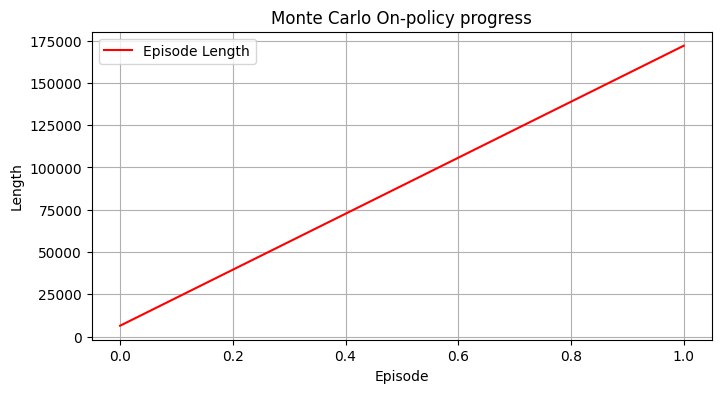

KeyboardInterrupt: 

In [382]:
import numpy as np
random.seed(1)


course = big_course

actions = np.array([(x, y) for x in range(-1, 2) for y in range(-1, 2)])

# Setup target and behaviour policies
# Actions here could be represented as an array of size (9) or (3, 3)
# If it were 9, then the actions are grouped to be (-1, -1), (-1, 0), ..., (1, 1) etc.
# If it were (3, 3), then there's 3 possible actions for each axis, but I think this would be more annoying to implement

target_q_values = np.zeros((len(course), len(course[0]), 6, 6, 9)) # len(x), len(y), 6 speeds up and down (0-6), 9 possible actions. If it were state values, we'd just need v = x, y, 5, 5
target_policy = np.zeros((len(course), len(course[0]), 6, 6, 9)) + 4 # Need an array for each state, default value set to (0, 0)
c_values = np.zeros(target_q_values.shape) # Need the same shape for our running importance sampling sum

behaviour_policy = np.zeros((len(course), len(course[0]), 6, 6, 9)) # Begin as equiprobable policy, will be stochastic
behaviour_q_values = np.zeros(behaviour_policy.shape)
behaviour_policy_counts = np.zeros(behaviour_policy.shape)

possible_actions = np.zeros((len(course), len(course[0]), 6, 6, 9)) + 1 # Initially all actions are possible
possible_actions = mark_possible(possible_actions)

behaviour_policy = init_equipropable_policy(behaviour_policy, possible_actions)

gamma = 1
epsilon = 0.05
default_probability = epsilon/len(actions)

race_track = RaceTrack(course, possible_actions)

plt.ion()
def on_policy_monte_carlo_control(race_track: RaceTrack, policy: np.array, q_values: np.array, counts: np.array, 
                                  gamma: float, epsilon: float, possible_actions: np.array, iterations: int = 100000):
    episode_length_history = []
    for i in range(iterations):
        state_action_trajectory = race_track.generate_episode(policy)
        current_return = 0

        for timestep, state_action in enumerate(state_action_trajectory[::-1]):
            current_return = gamma * current_return + -1 # Taking advantage of how the reward structure for the problem is
            # We don't need the explicit overall reward as it's just the negative of the length of the trajectory

            if state_action not in state_action_trajectory[:timestep]:
                counts[*state_action] += 1
                q_values[*state_action] += (current_return-q_values[*state_action])/counts[*state_action]
                
                best_action_q_value = -np.inf
                best_action = None
                for a in range(9):
                    if possible_actions[*state_action[:-1], a] == 1:
                        if q_values[*state_action[:-1], a] > best_action_q_value:
                            best_action_q_value = q_values[*state_action[:-1], a]
                            best_action = a
                
                possible_actions_sum = np.sum(possible_actions[*state_action[:-1]])
                random_probability = epsilon/possible_actions_sum
                for a in range(9):
                    if possible_actions[*state_action[:-1], a] == 1:
                        policy[*state_action[:-1], a] = random_probability
                    else:
                        policy[*state_action[:-1], a] = 0
                policy[*state_action[:-1], best_action] += (1-epsilon)


        episode_length_history.append(len(state_action_trajectory))
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(episode_length_history, label="Episode Length", color="red")
        plt.xlabel("Episode")
        plt.ylabel("Length")
        plt.title("Monte Carlo On-policy progress")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        
                
on_policy_monte_carlo_control(race_track, behaviour_policy, behaviour_q_values, behaviour_policy_counts, gamma, epsilon, possible_actions)



In [361]:
print(np.sum([0.95555556, 0.00555556, 0.00555556, 0.00555556, 0.00555556, 0.00555556, 0.00555556, 0.00555556, 0.00555556]))

1.00000004
